In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Loading data

In [2]:
topics = {
    0: 'News',
    1: 'Sport',
    2: 'Business',
    3: 'Tech',
    4: 'Health & Fitness',
    5: 'Money',
    6: 'Opinion',
}

geographies = {
    0: 'Region A',
    1: 'Region B',
    2: 'Region C',
    3: 'Region D',
    4: 'Region E',
    5: 'Region F'
}

In [3]:
df = pd.read_pickle("df.pickle")


In [ ]:
df.geography.replace(geographies, inplace=True)

In [29]:
df.geography = df.geography.astype(str)
df.current_topic = df.current_topic.astype(str)
df.visit_count_30_days = df.visit_count_30_days.astype(str)
df.most_favorite_topic = df.most_favorite_topic.astype(str)
df.least_favorite_topic = df.least_favorite_topic.astype(str)
df.topic_shown = df.topic_shown.astype(str)

In [30]:
df.head()

,id,geography,current_topic,visit_count_30_days,most_favorite_topic,least_favorite_topic,topic_shown
0,0,Region B,News,6,News,Tech,News
1,1,Region A,News,64,News,Business,News
2,2,Region B,News,22,Health & Fitness,Tech,Opinion
3,3,Region C,News,52,Health & Fitness,Tech,News
4,4,Region A,News,35,News,Business,News


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce640d42e8>,
      dtype=object)

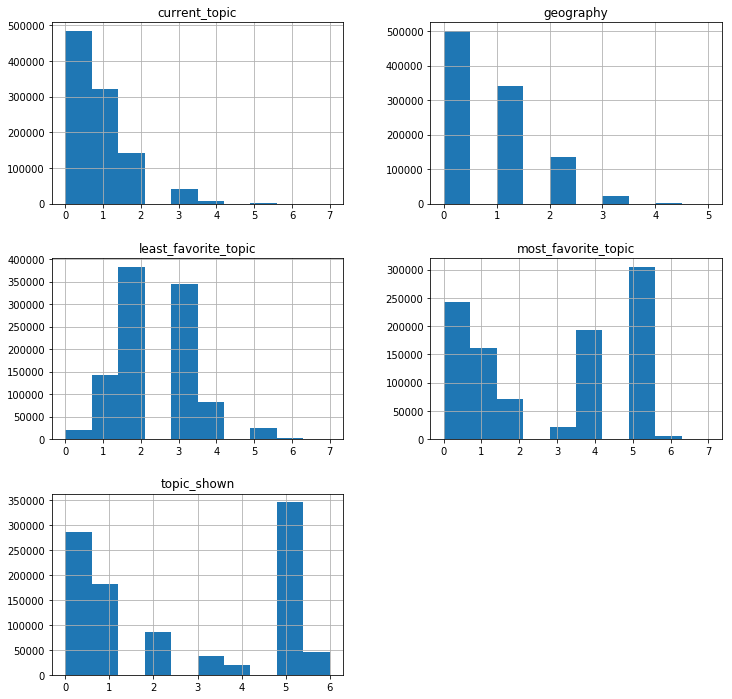

In [30]:
df.drop(['id', 'visit_count_30_days'], axis=1).replace(
    {v: k for k, v in topics.items()}
).replace(
    {v: k for k, v in geographies.items()}
).hist(figsize=(12, 12))

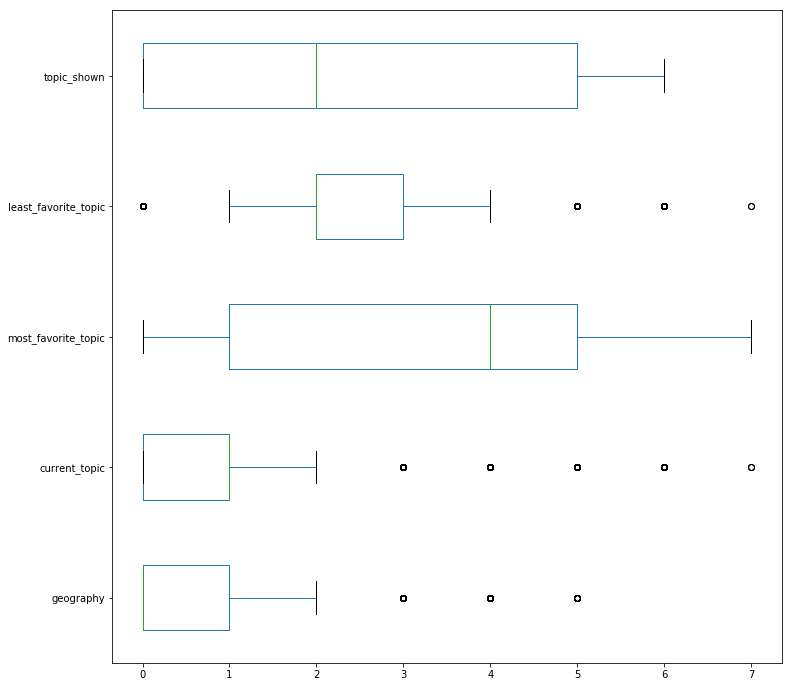

In [8]:
df.drop(['id', 'visit_count_30_days'], axis=1).replace(
    {v: k for k, v in topics.items()}
).replace(
    {v: k for k, v in geographies.items()}
).plot.box(vert=False, figsize=(12, 12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0c552d320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe0c5106940>]], dtype=object)

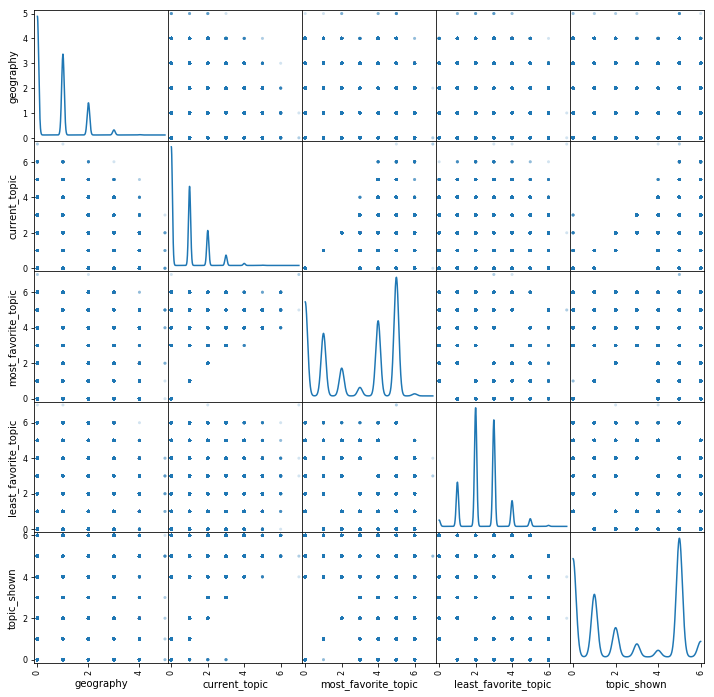

In [8]:
scatter_matrix(df.drop(['id', 'visit_count_30_days'], axis=1).replace(
    {v: k for k, v in topics.items()}
).replace(
    {v: k for k, v in geographies.items()}
), alpha=0.2, figsize=(12, 12), diagonal='kde')

# Build a simple model

In [5]:
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [31]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('topic_shown').replace({v: k for k, v in topics.items()})
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [32]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [33]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

In [34]:
feature_columns = []

feature_columns.append(feature_column.numeric_column('visit_count_30_days'))

feature = feature_column.categorical_column_with_vocabulary_list('geography', list(geographies.values()))
onehot = feature_column.indicator_column(feature)
feature_columns.append(onehot)

topic_features = ['current_topic', 'most_favorite_topic', 'least_favorite_topic']
for t in topic_features:
    feature = feature_column.categorical_column_with_vocabulary_list(t, list(topics.values()))
    onehot = feature_column.indicator_column(feature)
    feature_columns.append(onehot)

In [35]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)
model.fit(train_ds, validation_data=val_ds, epochs=5)
loss, accuracy = model.evaluate(test_ds)

Epoch 1/5


W0818 07:12:37.515063 139840762615616 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0818 07:12:37.549007 139840762615616 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4215: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0818 07:12:37.551814 139840762615616 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4270: VocabularyListCateg

UnimplementedError: Cast string to float is not supported [Op:Cast] name: sequential/dense_features_1/visit_count_30_days/Cast/

# Fairness Metric on the Dataset

In [19]:
from aif360.datasets import StructuredDataset
p = ['geography', 'most_favorite_topic']
ai360df = StructuredDataset(df, label_names=['topic_shown'], protected_attribute_names=p)

In [37]:
#from aif360.metrics import DatasetMetric
#privileged_groups = [{'geography': 0}]
#unprivileged_groups = [{'geography': 1}, {'geography': 2}, {'geography': 3}, {'geography': 4}, {'geography': 5}]
#metric = DatasetMetric(ai360df, privileged_groups, unprivileged_groups)
#metric.num_instances(), metric.num_instances(privileged=True), metric.num_instances(privileged=False)